# Setup

In [ ]:
# ================================================================================
# CÉLULA 1: INSTALAÇÃO
# ================================================================================
%pip install tabm rtdl_num_embeddings optuna

In [15]:
# ================================================================================
# CÉLULA 2: IMPORTS E CONFIGURAÇÕES
# ================================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import warnings
import matplotlib.pyplot as plt
import optuna

try:
    from tabm import TabM
    from rtdl_num_embeddings import PiecewiseLinearEmbeddings, LinearReLUEmbeddings
    print("TabM e rtdl_num_embeddings importados com sucesso!")
except ImportError:
    print("Bibliotecas não encontradas. Execute a célula de instalação acima e reinicie o kernel se necessário.")

warnings.filterwarnings('ignore')

# Configurações
N_SPLITS = 10
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {DEVICE}")

# URL do dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nomes das colunas
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

TabM e rtdl_num_embeddings importados com sucesso!
Usando dispositivo: cpu


In [21]:
# ================================================================================
# CÉLULA 3: CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS
# ================================================================================
def load_and_process_data(url, columns):
    # Carregar dados
    # O dataset tem valores ausentes marcados com '?'
    df = pd.read_csv(url, names=columns, na_values='?')
    
    # Tratar valores ausentes (remoção simples para este MVP)
    df = df.dropna()
    
    # Converter target para binário (0 = ausência, 1-4 = presença)
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Separar features numéricas e categóricas
    # Numéricas: age, trestbps, chol, thalach, oldpeak
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    # Categóricas: sex, cp, fbs, restecg, exang, slope, ca, thal
    cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # Padronizar features numéricas
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    
    # Codificar categóricas para índices (0 a C-1) para uso com TabM
    cat_cardinalities = []
    for col in cat_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        cat_cardinalities.append(len(le.classes_))
        
    X_num = df[num_features].values.astype(np.float32)
    X_cat = df[cat_features].values.astype(np.int64)
    y = df['target'].values.astype(np.float32).reshape(-1, 1)
        
    return X_num, X_cat, y, num_features, cat_features, cat_cardinalities

X_num, X_cat, y, feature_names_num, feature_names_cat, cat_cardinalities = load_and_process_data(url, columns)

print(f"Shape numérico: {X_num.shape}")
print(f"Shape categórico: {X_cat.shape}")
print(f"Cardinalidades: {cat_cardinalities}")
print(f"Distribuição do target: {np.bincount(y.flatten().astype(int))}")

Shape numérico: (297, 5)
Shape categórico: (297, 8)
Cardinalidades: [2, 4, 2, 3, 2, 3, 4, 3]
Distribuição do target: [160 137]


In [ ]:
# HERE

In [ ]:
# ================================================================================
# CÉLULA 4.2.1: ANÁLISE DE DISTRIBUIÇÕES - PLOTS SEPARADOS
# ================================================================================
# Recarregar dados originais (antes da seleção de features) para análise completa
def load_original_data(url, columns):
    df = pd.read_csv(url, names=columns, na_values='?')
    df = df.dropna()
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # NÃO padronizar para visualização
    X_num_orig = df[num_features].values.astype(np.float32)
    X_cat_orig = df[cat_features].values.astype(np.int64)
    y_orig = df['target'].values.astype(np.float32).reshape(-1, 1)
    
    return X_num_orig, X_cat_orig, y_orig, num_features, cat_features, df

X_num_orig, X_cat_orig, y_orig, num_features_orig, cat_features_orig, df_orig = load_original_data(url, columns)

# ================================================================================
# PLOT 1: OLDPEAK (Feature Numérica - Assimétrica à Direita)
# ================================================================================
plt.figure(figsize=(10, 6))
plt.hist(df_orig['oldpeak'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Oldpeak (Depressão do Segmento ST)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Adicionar estatísticas
mean_val = df_orig['oldpeak'].mean()
median_val = df_orig['oldpeak'].median()
std_val = df_orig['oldpeak'].std()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("OLDPEAK - Estatísticas Descritivas")
print("="*60)
print(f"Média: {mean_val:.4f}")
print(f"Mediana: {median_val:.4f}")
print(f"Desvio Padrão: {std_val:.4f}")
print(f"Mínimo: {df_orig['oldpeak'].min():.4f}")
print(f"Máximo: {df_orig['oldpeak'].max():.4f}")
print(f"Assimetria: Distribuição concentrada em valores próximos a zero com cauda longa")
print("="*60 + "\n")

# ================================================================================
# PLOT 2: CP (Tipo de Dor Torácica - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
cp_counts = df_orig['cp'].value_counts().sort_index()
cp_labels = ['Angina Típica', 'Angina Atípica', 'Dor Não-Anginosa', 'Assintomático']
colors_cp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = plt.bar(range(len(cp_counts)), cp_counts.values, color=colors_cp, edgecolor='black', alpha=0.8)
plt.xlabel('Tipo de Dor Torácica (cp)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(cp_counts)), cp_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, cp_counts.values)):
    pct = count / cp_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("CP (Tipo de Dor Torácica) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(cp_counts.items()):
    pct = count / cp_counts.sum() * 100
    print(f"{cp_labels[i]}: {count} amostras ({pct:.1f}%)")
print("="*60 + "\n")

# ================================================================================
# PLOT 3: THAL (Resultado de Perfusão com Tálio - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
thal_counts = df_orig['thal'].value_counts().sort_index()
thal_labels = ['Normal', 'Defeito Fixo', 'Defeito Reversível']
colors_thal = ['#2ECC71', '#E74C3C', '#F39C12']
bars = plt.bar(range(len(thal_counts)), thal_counts.values, color=colors_thal, edgecolor='black', alpha=0.8)
plt.xlabel('Resultado de Perfusão com Tálio (thal)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(thal_counts)), thal_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, thal_counts.values)):
    pct = count / thal_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("THAL (Resultado de Perfusão com Tálio) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(thal_counts.items()):
    pct = count / thal_counts.sum() * 100
    print(f"{thal_labels[i]}: {count} amostras ({pct:.1f}%)")
print("="*60 + "\n")

# ================================================================================
# PLOT 4: CA (Número de Vasos com Estenose - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
ca_counts = df_orig['ca'].value_counts().sort_index()
ca_labels = ['0 vasos', '1 vaso', '2 vasos', '3 vasos']
colors_ca = ['#3498DB', '#9B59B6', '#E67E22', '#C0392B']
bars = plt.bar(range(len(ca_counts)), ca_counts.values, color=colors_ca, edgecolor='black', alpha=0.8)
plt.xlabel('Número de Vasos Principais com Estenose (ca)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(ca_counts)), ca_labels)
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, ca_counts.values)):
    pct = count / ca_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("CA (Número de Vasos com Estenose) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(ca_counts.items()):
    pct = count / ca_counts.sum() * 100
    print(f"{ca_labels[i]}: {count} amostras ({pct:.1f}%)")
print("Observação: Concentração forte em valores baixos (0 e 1)")
print("="*60 + "\n")

In [ ]:
# ================================================================================
# CÉLULA 3.1: SELEÇÃO DE FEATURES (CONFIGURAÇÃO FINAL)
# ================================================================================
def select_features(X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities, features_to_remove):
    print(f"\n>>> Realizando Seleção de Features <<<")
    print(f"Features originais: {len(feature_names_num) + len(feature_names_cat)}")
    print(f"Removendo: {features_to_remove}")
    
    # Identificar índices para manter
    keep_num_indices = [i for i, f in enumerate(feature_names_num) if f not in features_to_remove]
    keep_cat_indices = [i for i, f in enumerate(feature_names_cat) if f not in features_to_remove]
    
    # Filtrar arrays
    X_num_selected = X_num[:, keep_num_indices]
    X_cat_selected = X_cat[:, keep_cat_indices]
    
    # Atualizar nomes
    new_feature_names_num = [feature_names_num[i] for i in keep_num_indices]
    new_feature_names_cat = [feature_names_cat[i] for i in keep_cat_indices]
    
    # Atualizar cardinalidades para as categóricas mantidas
    new_cat_cardinalities = [cat_cardinalities[i] for i in keep_cat_indices]
    
    return X_num_selected, X_cat_selected, new_feature_names_num, new_feature_names_cat, new_cat_cardinalities

# Lista Final de Features para remover (Mantendo apenas oldpeak, cp, exang, slope, ca, thal)
features_to_drop = ['sex', 'age', 'trestbps', 'restecg', 'fbs', 'thalach', 'chol']

X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities = select_features(
    X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities, features_to_drop
)

print(f"Shape numérico atualizado: {X_num.shape}")
print(f"Shape categórico atualizado: {X_cat.shape}")
print(f"Features Numéricas restantes: {feature_names_num}")
print(f"Features Categóricas restantes: {feature_names_cat}")
print(f"Cardinalidades atualizadas: {cat_cardinalities}")


>>> Realizando Seleção de Features <<<
Features originais: 13
Removendo: ['sex', 'age', 'trestbps', 'restecg', 'fbs', 'thalach', 'chol']
Shape numérico atualizado: (297, 1)
Shape categórico atualizado: (297, 5)
Features Numéricas restantes: ['oldpeak']
Features Categóricas restantes: ['cp', 'exang', 'slope', 'ca', 'thal']
Cardinalidades atualizadas: [4, 2, 3, 4, 3]


In [27]:
# ================================================================================
# CÉLULA SMOTE
# ================================================================================
# Implementação de SMOTE (Synthetic Minority Over-sampling Technique)
# para gerar dados sintéticos e melhorar a generalização em folds problemáticos

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean

def smote_hybrid(X_num, X_cat, y, sampling_strategy=0.5, k_neighbors=5, random_state=42):
    """
    Implementa SMOTE híbrido para dados mistos (numéricos + categóricos).
    
    Args:
        X_num: Array de features numéricas (n_samples, n_num_features)
        X_cat: Array de features categóricas (n_samples, n_cat_features)
        y: Array de labels (n_samples,)
        sampling_strategy: Razão de oversampling (0.5 = 50% da classe majoritária)
        k_neighbors: Número de vizinhos para KNN
        random_state: Seed para reprodutibilidade
        
    Returns:
        X_num_smote, X_cat_smote, y_smote: Dados aumentados com amostras sintéticas
    """
    np.random.seed(random_state)
    
    # Identificar classes
    unique_classes = np.unique(y)
    if len(unique_classes) != 2:
        raise ValueError("SMOTE requer classificação binária")
    
    # Classe minoritária e majoritária
    class_counts = np.bincount(y.astype(int).flatten())
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)
    
    minority_mask = (y == minority_class).flatten()
    majority_mask = (y == majority_class).flatten()
    
    X_num_minority = X_num[minority_mask]
    X_cat_minority = X_cat[minority_mask]
    y_minority = y[minority_mask]
    
    n_minority = X_num_minority.shape[0]
    n_majority = np.sum(majority_mask)
    
    # Calcular número de amostras sintéticas a gerar
    n_synthetic = max(0, int((n_majority * sampling_strategy) - n_minority))
    
    if n_synthetic == 0:
        print(f"SMOTE: Sem necessidade de oversampling (minoritária: {n_minority}, majoritária: {n_majority})")
        print(f"  Dica: Use sampling_strategy ≥ {np.ceil((n_minority / n_majority) * 100) / 100} para gerar amostras")
        return X_num, X_cat, y
    
    print(f"SMOTE: Gerando {n_synthetic} amostras sintéticas")
    print(f"  Classe minoritária: {minority_class} ({n_minority} amostras)")
    print(f"  Classe majoritária: {majority_class} ({n_majority} amostras)")
    
    # Normalizar features numéricas para KNN (escala 0-1)
    X_num_min_norm = (X_num_minority - X_num_minority.min(axis=0)) / (X_num_minority.max(axis=0) - X_num_minority.min(axis=0) + 1e-8)
    
    # Encontrar k vizinhos mais próximos (usando apenas features numéricas para distância)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(X_num_min_norm)
    distances, indices = nbrs.kneighbors(X_num_min_norm)
    
    # Gerar amostras sintéticas
    X_num_synthetic = []
    X_cat_synthetic = []
    
    for _ in range(n_synthetic):
        # Selecionar aleatoriamente uma amostra minoritária
        idx_minority = np.random.randint(0, n_minority)
        
        # Selecionar aleatoriamente um vizinho (excluindo o próprio índice)
        neighbor_idx = np.random.choice(indices[idx_minority][1:])
        
        # Interpolação linear para features numéricas
        alpha = np.random.rand(X_num_minority.shape[1])
        X_num_new = X_num_minority[idx_minority] + alpha * (X_num_minority[neighbor_idx] - X_num_minority[idx_minority])
        
        # Para features categóricas: selecionar aleatoriamente entre as duas amostras
        X_cat_new = np.where(
            np.random.rand(X_cat_minority.shape[1]) > 0.5,
            X_cat_minority[idx_minority],
            X_cat_minority[neighbor_idx]
        )
        
        X_num_synthetic.append(X_num_new)
        X_cat_synthetic.append(X_cat_new)
    
    # Concatenar dados originais com sintéticos
    X_num_smote = np.vstack([X_num, np.array(X_num_synthetic)])
    X_cat_smote = np.vstack([X_cat, np.array(X_cat_synthetic)])
    y_smote = np.vstack([y, np.full((n_synthetic, 1), minority_class)])
    
    print(f"  Dataset original: {X_num.shape[0]} amostras")
    print(f"  Dataset com SMOTE: {X_num_smote.shape[0]} amostras")
    print(f"  Nova distribuição: {np.bincount(y_smote.astype(int).flatten())}")
    
    return X_num_smote, X_cat_smote, y_smote

# Teste com sampling_strategy=1.0 (balanceamento perfeito - recomendado na literatura)
print("\n>>> TESTE DE SMOTE <<<")
print("Usando sampling_strategy=1.0 (balanceamento perfeito - conforme literatura)")
X_num_test, X_cat_test, y_test = smote_hybrid(X_num, X_cat, y, sampling_strategy=1.0, k_neighbors=5)
print(f"\nDistribuição original: {np.bincount(y.astype(int).flatten())}")
print(f"Distribuição com SMOTE: {np.bincount(y_test.astype(int).flatten())}")
print(f"Amostras sintéticas geradas: {y_test.shape[0] - y.shape[0]}")


>>> TESTE DE SMOTE <<<
Usando sampling_strategy=1.0 (balanceamento perfeito - conforme literatura)
SMOTE: Gerando 23 amostras sintéticas
  Classe minoritária: 1 (137 amostras)
  Classe majoritária: 0 (160 amostras)
  Dataset original: 297 amostras
  Dataset com SMOTE: 320 amostras
  Nova distribuição: [160 160]

Distribuição original: [160 137]
Distribuição com SMOTE: [160 160]
Amostras sintéticas geradas: 23


In [ ]:
# ================================================================================
# CÉLULA 4: DEFINIÇÃO DO MODELO E FUNÇÕES DE TREINAMENTO
# ================================================================================
import rtdl_num_embeddings

def create_tabm_model(n_num_features, cat_cardinalities, params, X_train=None, d_out=1):
    """
    Cria o modelo TabM com hiperparâmetros dinâmicos.
    Adiciona suporte a Embeddings Numéricos se especificado.
    """
    
    # Configuração de Embeddings Numéricos (Opcional mas recomendado)
    num_embeddings = None
    if params.get('use_embeddings', False) and X_train is not None:
        # Usando PiecewiseLinearEmbeddings com cálculo de bins
        bins = rtdl_num_embeddings.compute_bins(X_train, n_bins=params['n_bins'])
        
        num_embeddings = PiecewiseLinearEmbeddings(
            bins=bins,
            d_embedding=params['d_embedding'],
            activation=True, # Geralmente False para TabM
            version='B'
        )

    model = TabM.make(
        n_num_features=n_num_features,
        cat_cardinalities=cat_cardinalities,
        d_out=d_out,
        n_blocks=params['n_blocks'],
        d_block=params['d_block'],
        dropout=params.get('dropout', 0.1),
        num_embeddings=num_embeddings
    )
    return model

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for X_num_batch, X_cat_batch, y_batch in loader:
        X_num_batch = X_num_batch.to(device).float()
        X_cat_batch = X_cat_batch.to(device)
        y_batch = y_batch.to(device).float()
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_num_batch, X_cat_batch)
        
        # Loss média das k predições independentes
        y_target_expanded = y_batch.unsqueeze(1).expand(-1, model.k, -1)
        loss = criterion(y_pred.reshape(-1, 1), y_target_expanded.reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_num_batch.size(0)
        
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_num_batch, X_cat_batch, y_batch in loader:
            X_num_batch = X_num_batch.to(device).float()
            X_cat_batch = X_cat_batch.to(device)
            
            # Ensemble mean na inferência
            y_pred = model(X_num_batch, X_cat_batch)
            probs = torch.sigmoid(y_pred).mean(dim=1)
            
            all_preds.append(probs.cpu().numpy())
            all_targets.append(y_batch.numpy())
            
    return np.vstack(all_preds), np.vstack(all_targets)

In [32]:
# ================================================================================
# CÉLULA 5: OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) - COM SMOTE
# ================================================================================
import json
import os

def objective(trial):
    # Espaço de busca sugerido na documentação do TabM
    params = {
        'n_blocks': trial.suggest_int('n_blocks', 1, 4), 
        'd_block': trial.suggest_int('d_block', 64, 512, step=16), 
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        
        # Configurações de Embeddings
        'use_embeddings': True,
        'd_embedding': trial.suggest_int('d_embedding', 8, 32, step=4),
        'n_bins': trial.suggest_int('n_bins', 2, 64),
        
        # Configurações de SMOTE (conforme literatura)
        'use_smote': True,
        'smote_sampling_strategy': trial.suggest_float('smote_sampling_strategy', 0.86, 1.0)
    }
    
    # Validação cruzada interna (3 folds para ser rápido)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    
    for train_idx, val_idx in skf.split(X_num, y):
        # Split simples
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Aplicar SMOTE ao conjunto de treinamento
        if params['use_smote']:
            X_num_train, X_cat_train, y_train = smote_hybrid(
                X_num_train, X_cat_train, y_train,
                sampling_strategy=params['smote_sampling_strategy'],
                k_neighbors=5,
                random_state=RANDOM_STATE
            )
        
        train_ds = TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train))
        val_ds = TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val))
        
        train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
        
        # Passar X_num_train para calcular os bins dos embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        # Treino curto (30 épocas)
        best_fold_auc = 0
        for epoch in range(30):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            try:
                auc = roc_auc_score(val_targets, val_preds)
            except:
                auc = 0.5
            best_fold_auc = max(best_fold_auc, auc)
            
            # Pruning do Optuna
            trial.report(best_fold_auc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        scores.append(best_fold_auc)
    
    return np.mean(scores)

print("Iniciando estudo de otimização com SMOTE (sampling_strategy: 0.86-1.0)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

print("\nMelhores hiperparâmetros:")
best_params = study.best_params
best_params['use_embeddings'] = True 
best_params['use_smote'] = True
print(best_params)

# Salvar em JSON
output_dir = '/home/matheus/ifpe/tcc/v4/mvp-heart-disease-function/TabM'
os.makedirs(output_dir, exist_ok=True)
json_path = os.path.join(output_dir, 'best_params_tabm.json')

with open(json_path, 'w') as f:
    json.dump(best_params, f, indent=4)
    
print(f"Melhores parâmetros salvos em: {json_path}")

[I 2025-12-03 01:59:19,818] A new study created in memory with name: no-name-395635c5-f7bb-4a3c-9ebf-88e6196ce55f


Iniciando estudo de otimização com SMOTE (sampling_strategy: 0.86-1.0)...
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [107 104]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [107 104]


[I 2025-12-03 01:59:20,917] Trial 0 finished with value: 0.8806359864558754 and parameters: {'n_blocks': 1, 'd_block': 80, 'lr': 0.0001531012214710029, 'weight_decay': 1.4710669302599713e-05, 'dropout': 0.17630627447767566, 'd_embedding': 16, 'n_bins': 2, 'smote_sampling_strategy': 0.97684724555112}. Best is trial 0 with value: 0.8806359864558754.


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]


[I 2025-12-03 01:59:23,364] Trial 1 finished with value: 0.8969228077164152 and parameters: {'n_blocks': 3, 'd_block': 80, 'lr': 0.0024399615663557995, 'weight_decay': 0.015187902019219796, 'dropout': 0.1469480245878046, 'd_embedding': 8, 'n_bins': 8, 'smote_sampling_strategy': 0.9969761003333842}. Best is trial 1 with value: 0.8969228077164152.


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [107 104]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [107 104]


[I 2025-12-03 01:59:32,769] Trial 2 finished with value: 0.9134614713762771 and parameters: {'n_blocks': 2, 'd_block': 384, 'lr': 0.002326106988166629, 'weight_decay': 0.013205551778183694, 'dropout': 0.11091346760362036, 'd_embedding': 12, 'n_bins': 31, 'smote_sampling_strategy': 0.9794994536757449}. Best is trial 2 with value: 0.9134614713762771.


SMOTE: Gerando 4 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 202 amostras
  Nova distribuição: [106  96]
SMOTE: Gerando 6 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 204 amostras
  Nova distribuição: [107  97]
SMOTE: Gerando 6 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 204 amostras
  Nova distribuição: [107  97]


[I 2025-12-03 01:59:36,047] Trial 3 finished with value: 0.9092230245619485 and parameters: {'n_blocks': 1, 'd_block': 272, 'lr': 0.00026042995153764133, 'weight_decay': 2.0909397244704188e-05, 'dropout': 0.493628694887084, 'd_embedding': 16, 'n_bins': 41, 'smote_sampling_strategy': 0.9087208471234595}. Best is trial 2 with value: 0.9134614713762771.


SMOTE: Gerando 6 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 204 amostras
  Nova distribuição: [106  98]
SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [107  99]
SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [107  99]


[I 2025-12-03 01:59:41,709] Trial 4 finished with value: 0.900767286595075 and parameters: {'n_blocks': 2, 'd_block': 272, 'lr': 0.00030615588002923325, 'weight_decay': 0.05556333586617498, 'dropout': 0.12024625892554758, 'd_embedding': 28, 'n_bins': 43, 'smote_sampling_strategy': 0.9335145636438813}. Best is trial 2 with value: 0.9134614713762771.


SMOTE: Gerando 2 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 200 amostras
  Nova distribuição: [106  94]
SMOTE: Gerando 4 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 202 amostras
  Nova distribuição: [107  95]
SMOTE: Gerando 4 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 202 amostras
  Nova distribuição: [107  95]


[I 2025-12-03 01:59:51,017] Trial 5 finished with value: 0.9189389872964752 and parameters: {'n_blocks': 4, 'd_block': 192, 'lr': 0.0029867522040174068, 'weight_decay': 0.031547452249743126, 'dropout': 0.3984275230250282, 'd_embedding': 8, 'n_bins': 58, 'smote_sampling_strategy': 0.8893846372682632}. Best is trial 5 with value: 0.9189389872964752.


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]


[I 2025-12-03 01:59:51,264] Trial 6 pruned. 


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]


[I 2025-12-03 01:59:53,329] Trial 7 pruned. 
[I 2025-12-03 01:59:53,475] Trial 8 pruned. 
[I 2025-12-03 01:59:53,505] Trial 9 pruned. 


SMOTE: Gerando 5 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 203 amostras
  Nova distribuição: [106  97]
SMOTE: Gerando 3 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 201 amostras
  Nova distribuição: [106  95]
SMOTE: Sem necessidade de oversampling (minoritária: 92, majoritária: 106)
  Dica: Use sampling_strategy ≥ 0.87 para gerar amostras


[I 2025-12-03 01:59:53,630] Trial 10 pruned. 


SMOTE: Sem necessidade de oversampling (minoritária: 92, majoritária: 106)
  Dica: Use sampling_strategy ≥ 0.87 para gerar amostras


[I 2025-12-03 01:59:53,877] Trial 11 pruned. 


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]


[I 2025-12-03 01:59:54,347] Trial 12 pruned. 


SMOTE: Gerando 2 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 200 amostras
  Nova distribuição: [106  94]
SMOTE: Gerando 3 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 201 amostras
  Nova distribuição: [107  94]
SMOTE: Gerando 3 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 201 amostras
  Nova distribuição: [107  94]


[I 2025-12-03 01:59:58,171] Trial 13 finished with value: 0.9120978314321371 and parameters: {'n_blocks': 2, 'd_block': 160, 'lr': 0.0047659931143161265, 'weight_decay': 0.017645928137047347, 'dropout': 0.3401562592738668, 'd_embedding': 12, 'n_bins': 26, 'smote_sampling_strategy': 0.8870433897958587}. Best is trial 5 with value: 0.9189389872964752.


SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]


[I 2025-12-03 02:00:13,382] Trial 14 finished with value: 0.9147059419277085 and parameters: {'n_blocks': 3, 'd_block': 384, 'lr': 0.0006209311493208086, 'weight_decay': 0.0002188274776404009, 'dropout': 0.09431861459885506, 'd_embedding': 16, 'n_bins': 32, 'smote_sampling_strategy': 0.9537232401323174}. Best is trial 5 with value: 0.9189389872964752.


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [107 101]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [107 101]


[I 2025-12-03 02:00:20,368] Trial 15 finished with value: 0.9133450027063493 and parameters: {'n_blocks': 4, 'd_block': 176, 'lr': 0.0005737074544689715, 'weight_decay': 0.0001976937724317268, 'dropout': 0.2696580912212194, 'd_embedding': 20, 'n_bins': 54, 'smote_sampling_strategy': 0.9516148605354157}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:00:20,549] Trial 16 pruned. 


SMOTE: Gerando 2 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 200 amostras
  Nova distribuição: [106  94]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]


[I 2025-12-03 02:00:43,535] Trial 17 finished with value: 0.9081413850881842 and parameters: {'n_blocks': 4, 'd_block': 448, 'lr': 0.0004154839543257276, 'weight_decay': 0.0009065498736678218, 'dropout': 0.06163522053622259, 'd_embedding': 24, 'n_bins': 21, 'smote_sampling_strategy': 0.9547493378558434}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:00:43,637] Trial 18 pruned. 


SMOTE: Gerando 6 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 204 amostras
  Nova distribuição: [106  98]
SMOTE: Gerando 2 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 200 amostras
  Nova distribuição: [106  94]


[I 2025-12-03 02:00:43,842] Trial 19 pruned. 
[I 2025-12-03 02:00:43,906] Trial 20 pruned. 
[I 2025-12-03 02:00:44,019] Trial 21 pruned. 


SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 205 amostras
  Nova distribuição: [106  99]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  

[I 2025-12-03 02:00:47,334] Trial 22 finished with value: 0.9140169200282227 and parameters: {'n_blocks': 1, 'd_block': 336, 'lr': 0.003151886960674139, 'weight_decay': 0.010127106356753722, 'dropout': 0.07553032868976076, 'd_embedding': 12, 'n_bins': 39, 'smote_sampling_strategy': 0.9953129570261187}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:00:47,381] Trial 23 pruned. 
[I 2025-12-03 02:00:47,444] Trial 24 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 5 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 203 amostras
  Nova distribuição: [106  97]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]


[I 2025-12-03 02:00:47,587] Trial 25 pruned. 
[I 2025-12-03 02:00:47,775] Trial 26 pruned. 


SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]
SMOTE: Gerando 3 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 201 amostras
  Nova distribuição: [106  95]


[I 2025-12-03 02:00:47,804] Trial 27 pruned. 
[I 2025-12-03 02:00:47,960] Trial 28 pruned. 
[I 2025-12-03 02:00:47,995] Trial 29 pruned. 


SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]
SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Sem necessidade de oversampling (minoritária: 92, majoritária: 106)
  Dica: Use sampling_strategy ≥ 0.87 para gerar amostras


[I 2025-12-03 02:00:48,395] Trial 30 pruned. 
[I 2025-12-03 02:00:48,577] Trial 31 pruned. 


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]


[I 2025-12-03 02:00:59,204] Trial 32 finished with value: 0.9175744471114081 and parameters: {'n_blocks': 2, 'd_block': 464, 'lr': 0.0025621129100866476, 'weight_decay': 0.010010894878085373, 'dropout': 0.12457888620642446, 'd_embedding': 16, 'n_bins': 28, 'smote_sampling_strategy': 0.9969391413498387}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:00:59,268] Trial 33 pruned. 
[I 2025-12-03 02:00:59,413] Trial 34 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]


[I 2025-12-03 02:00:59,456] Trial 35 pruned. 
[I 2025-12-03 02:00:59,576] Trial 36 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]


[I 2025-12-03 02:00:59,824] Trial 37 pruned. 
[I 2025-12-03 02:00:59,906] Trial 38 pruned. 
[I 2025-12-03 02:00:59,955] Trial 39 pruned. 
[I 2025-12-03 02:00:59,991] Trial 40 pruned. 


SMOTE: Gerando 4 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 202 amostras
  Nova distribuição: [106  96]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]


[I 2025-12-03 02:01:00,107] Trial 41 pruned. 
[I 2025-12-03 02:01:00,206] Trial 42 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]


[I 2025-12-03 02:01:00,376] Trial 43 pruned. 
[I 2025-12-03 02:01:00,472] Trial 44 pruned. 


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]


[I 2025-12-03 02:01:00,661] Trial 45 pruned. 
[I 2025-12-03 02:01:00,788] Trial 46 pruned. 
[I 2025-12-03 02:01:00,875] Trial 47 pruned. 


SMOTE: Gerando 6 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 204 amostras
  Nova distribuição: [106  98]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:01,066] Trial 48 pruned. 


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Sem necessidade de oversampling (minoritária: 92, majoritária: 106)
  Dica: Use sampling_strategy ≥ 0.87 para gerar amostras


[I 2025-12-03 02:01:01,263] Trial 49 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]
SMOTE: Gerando 15 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 213 amostras
  Nova distribuição: [107 106]


[I 2025-12-03 02:01:12,992] Trial 50 finished with value: 0.9174359225387695 and parameters: {'n_blocks': 2, 'd_block': 384, 'lr': 0.0017559212631724284, 'weight_decay': 0.015355610083082859, 'dropout': 0.4127212923025113, 'd_embedding': 20, 'n_bins': 27, 'smote_sampling_strategy': 0.9932292259817417}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:01:13,131] Trial 51 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]


[I 2025-12-03 02:01:13,278] Trial 52 pruned. 
[I 2025-12-03 02:01:13,405] Trial 53 pruned. 


SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]


[I 2025-12-03 02:01:13,496] Trial 54 pruned. 


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]


[I 2025-12-03 02:01:13,802] Trial 55 pruned. 
[I 2025-12-03 02:01:13,934] Trial 56 pruned. 
[I 2025-12-03 02:01:13,984] Trial 57 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 3 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 201 amostras
  Nova distribuição: [106  95]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  

[I 2025-12-03 02:01:25,122] Trial 58 finished with value: 0.9179832690223723 and parameters: {'n_blocks': 2, 'd_block': 384, 'lr': 0.0034173389679522785, 'weight_decay': 0.0003039274940104922, 'dropout': 0.4321427187316304, 'd_embedding': 16, 'n_bins': 39, 'smote_sampling_strategy': 0.9593800071675985}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:01:25,287] Trial 59 pruned. 


SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 205 amostras
  Nova distribuição: [106  99]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]


[I 2025-12-03 02:01:33,190] Trial 60 finished with value: 0.9138855973829996 and parameters: {'n_blocks': 3, 'd_block': 208, 'lr': 0.004361317571381192, 'weight_decay': 0.00025862253474765476, 'dropout': 0.47699275221531634, 'd_embedding': 16, 'n_bins': 45, 'smote_sampling_strategy': 0.9563611966465986}. Best is trial 5 with value: 0.9189389872964752.


SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [107 102]


[I 2025-12-03 02:01:39,954] Trial 61 finished with value: 0.918392991174263 and parameters: {'n_blocks': 3, 'd_block': 176, 'lr': 0.004284188154622786, 'weight_decay': 0.00023933268552809225, 'dropout': 0.47849274418312243, 'd_embedding': 16, 'n_bins': 41, 'smote_sampling_strategy': 0.9586444488180167}. Best is trial 5 with value: 0.9189389872964752.


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [107 101]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [107 101]


[I 2025-12-03 02:01:46,113] Trial 62 finished with value: 0.9144297930233579 and parameters: {'n_blocks': 3, 'd_block': 160, 'lr': 0.003731705754594522, 'weight_decay': 0.0007988265415705206, 'dropout': 0.4585176204497843, 'd_embedding': 20, 'n_bins': 57, 'smote_sampling_strategy': 0.9486419684835978}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:01:46,197] Trial 63 pruned. 
[I 2025-12-03 02:01:46,282] Trial 64 pruned. 


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 205 amostras
  Nova distribuição: [106  99]
SMOTE: Gerando 6 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 204 amostras
  Nova distribuição: [106  98]


[I 2025-12-03 02:01:46,335] Trial 65 pruned. 
[I 2025-12-03 02:01:46,409] Trial 66 pruned. 
[I 2025-12-03 02:01:46,505] Trial 67 pruned. 


SMOTE: Gerando 5 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 203 amostras
  Nova distribuição: [106  97]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:46,592] Trial 68 pruned. 
[I 2025-12-03 02:01:46,707] Trial 69 pruned. 
[I 2025-12-03 02:01:46,772] Trial 70 pruned. 


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 1 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 199 amostras
  Nova distribuição: [106  93]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]


[I 2025-12-03 02:01:46,853] Trial 71 pruned. 


SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 205 amostras
  Nova distribuição: [106  99]


[I 2025-12-03 02:01:47,099] Trial 72 pruned. 
[I 2025-12-03 02:01:47,147] Trial 73 pruned. 
[I 2025-12-03 02:01:47,217] Trial 74 pruned. 


SMOTE: Gerando 3 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 201 amostras
  Nova distribuição: [106  95]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:47,421] Trial 75 pruned. 
[I 2025-12-03 02:01:47,506] Trial 76 pruned. 
[I 2025-12-03 02:01:47,577] Trial 77 pruned. 
[I 2025-12-03 02:01:47,609] Trial 78 pruned. 


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 4 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 202 amostras
  Nova distribuição: [106  96]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]


[I 2025-12-03 02:01:47,663] Trial 79 pruned. 
[I 2025-12-03 02:01:47,785] Trial 80 pruned. 


SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:47,880] Trial 81 pruned. 
[I 2025-12-03 02:01:47,995] Trial 82 pruned. 


SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:48,099] Trial 83 pruned. 
[I 2025-12-03 02:01:48,205] Trial 84 pruned. 


SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 205 amostras
  Nova distribuição: [106  99]


[I 2025-12-03 02:01:48,618] Trial 85 pruned. 
[I 2025-12-03 02:01:48,808] Trial 86 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]


[I 2025-12-03 02:01:49,000] Trial 87 pruned. 
[I 2025-12-03 02:01:49,131] Trial 88 pruned. 


SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 205 amostras
  Nova distribuição: [106  99]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:49,394] Trial 89 pruned. 
[I 2025-12-03 02:01:49,469] Trial 90 pruned. 
[I 2025-12-03 02:01:49,572] Trial 91 pruned. 


SMOTE: Gerando 13 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 211 amostras
  Nova distribuição: [106 105]
SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]


[I 2025-12-03 02:01:49,701] Trial 92 pruned. 
[I 2025-12-03 02:01:49,748] Trial 93 pruned. 


SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [106 104]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [107 103]
SMOTE: Gerando 12 amostras sintéticas
  Classe minoritária: 1 (91 amostras)
  Classe majoritária: 0 (107 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 210 amostras
  Nova distribuição: [107 103]


[I 2025-12-03 02:01:53,830] Trial 94 finished with value: 0.9134799263152802 and parameters: {'n_blocks': 1, 'd_block': 384, 'lr': 0.0031246679818619887, 'weight_decay': 0.005744819929356311, 'dropout': 0.06811364895946656, 'd_embedding': 12, 'n_bins': 28, 'smote_sampling_strategy': 0.9656571529768169}. Best is trial 5 with value: 0.9189389872964752.
[I 2025-12-03 02:01:53,902] Trial 95 pruned. 
[I 2025-12-03 02:01:53,955] Trial 96 pruned. 
[I 2025-12-03 02:01:54,002] Trial 97 pruned. 


SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]
SMOTE: Gerando 8 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 206 amostras
  Nova distribuição: [106 100]
SMOTE: Gerando 10 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 208 amostras
  Nova distribuição: [106 102]
SMOTE: Gerando 9 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 207 amostras
  Nova distribuição: [106 101]


[I 2025-12-03 02:01:54,093] Trial 98 pruned. 
[I 2025-12-03 02:01:54,140] Trial 99 pruned. 


SMOTE: Gerando 11 amostras sintéticas
  Classe minoritária: 1 (92 amostras)
  Classe majoritária: 0 (106 amostras)
  Dataset original: 198 amostras
  Dataset com SMOTE: 209 amostras
  Nova distribuição: [106 103]

Melhores hiperparâmetros:
{'n_blocks': 4, 'd_block': 192, 'lr': 0.0029867522040174068, 'weight_decay': 0.031547452249743126, 'dropout': 0.3984275230250282, 'd_embedding': 8, 'n_bins': 58, 'smote_sampling_strategy': 0.8893846372682632, 'use_embeddings': True, 'use_smote': True}
Melhores parâmetros salvos em: /home/matheus/ifpe/tcc/v4/mvp-heart-disease-function/TabM/best_params_tabm.json



>>> Rodando Experimento Final com Melhores Parâmetros (com SMOTE) <<<

Fold 1/10
  Aplicando SMOTE...
SMOTE: Gerando 5 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 272 amostras
  Nova distribuição: [144 128]
  AUC: 0.9330 | Acc (0.5): 0.5333 | Acc (Opt 0.49): 0.8667

Fold 2/10
  Aplicando SMOTE...
SMOTE: Gerando 5 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 272 amostras
  Nova distribuição: [144 128]
  AUC: 0.9621 | Acc (0.5): 0.7000 | Acc (Opt 0.49): 0.9333

Fold 3/10
  Aplicando SMOTE...
SMOTE: Gerando 5 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 272 amostras
  Nova distribuição: [144 128]
  AUC: 1.0000 | Acc (0.5): 0.9667 | Acc (Opt 0.52): 0.9667

Fold 4/10
  Apli

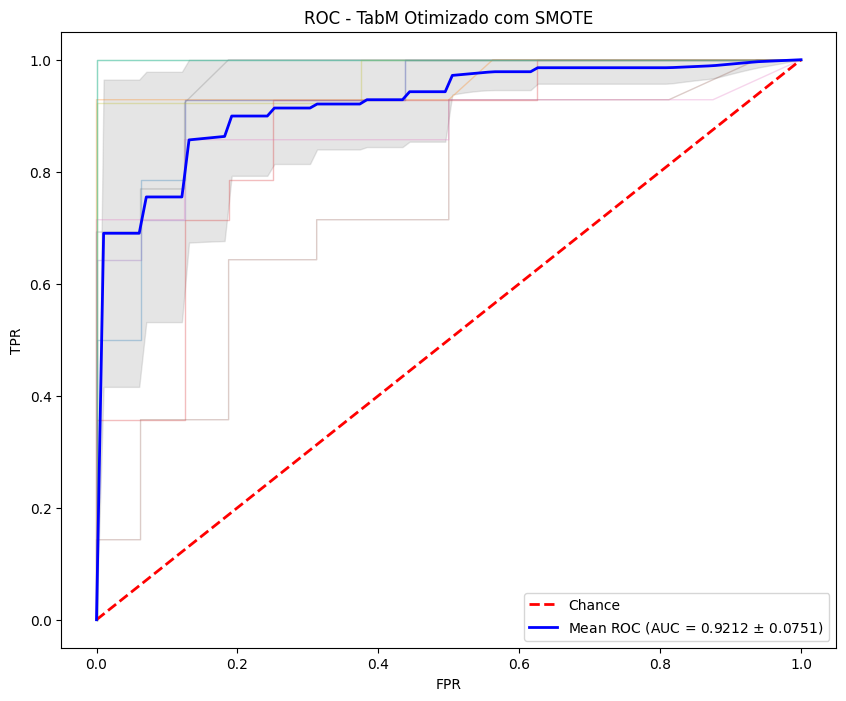


=== RESULTADOS FINAIS ===
Média AUC-ROC: 0.9250 (+/- 0.0751)
Média Accuracy (Threshold 0.5): 0.6974 (+/- 0.1480)
Média Accuracy (Threshold Otimizado): 0.8725 (+/- 0.0768)

=== INFORMAÇÕES DE SMOTE ===
Fold 1: 267 → 272 (+5 sintéticas)
Fold 2: 267 → 272 (+5 sintéticas)
Fold 3: 267 → 272 (+5 sintéticas)
Fold 4: 267 → 272 (+5 sintéticas)
Fold 5: 267 → 272 (+5 sintéticas)
Fold 6: 267 → 272 (+5 sintéticas)
Fold 7: 267 → 272 (+5 sintéticas)
Fold 8: 268 → 272 (+4 sintéticas)
Fold 9: 268 → 272 (+4 sintéticas)
Fold 10: 268 → 272 (+4 sintéticas)


In [33]:
# ================================================================================
# CÉLULA 6: EXECUÇÃO DO EXPERIMENTO FINAL (COM SMOTE E THRESHOLD OTIMIZADO)
# ================================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def run_final_experiment(params):
    print("\n>>> Rodando Experimento Final com Melhores Parâmetros (com SMOTE) <<<")
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    fold_auc_results = []
    fold_acc_results = []
    fold_opt_acc_results = [] # Acurácia com threshold otimizado
    fold_smote_info = []  # Informações sobre SMOTE por fold
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_num, y)):
        print(f"\nFold {fold+1}/{N_SPLITS}")
        
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Aplicar SMOTE ao conjunto de treinamento
        if params.get('use_smote', False):
            print(f"  Aplicando SMOTE...")
            X_num_train_orig_size = X_num_train.shape[0]
            X_num_train, X_cat_train, y_train = smote_hybrid(
                X_num_train, X_cat_train, y_train,
                sampling_strategy=params.get('smote_sampling_strategy', 0.8),
                k_neighbors=5,
                random_state=RANDOM_STATE + fold  # Seed diferente por fold
            )
            fold_smote_info.append({
                'fold': fold + 1,
                'original_size': X_num_train_orig_size,
                'smote_size': X_num_train.shape[0],
                'increase': X_num_train.shape[0] - X_num_train_orig_size
            })
        
        train_loader = DataLoader(TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train)), batch_size=256, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val)), batch_size=256, shuffle=False)
        
        # Passar X_num_train para embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        best_val_auc = 0
        best_epoch_preds = None
        best_epoch_targets = None
        patience = 15 
        no_improve = 0
        
        for epoch in range(100):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            
            try:
                val_auc = roc_auc_score(val_targets, val_preds)
            except:
                val_auc = 0.5
            
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_epoch_preds = val_preds
                best_epoch_targets = val_targets
                no_improve = 0
            else:
                no_improve += 1
                
            if no_improve >= patience:
                break
        
        # Calcular métricas finais para o melhor modelo do fold
        if best_epoch_preds is not None:
            # 1. ROC e Threshold Otimizado (Youden's J)
            fpr, tpr, thresholds = roc_curve(best_epoch_targets, best_epoch_preds)
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]
            
            # Acurácias
            acc_default = accuracy_score(best_epoch_targets, (best_epoch_preds > 0.5).astype(int))
            acc_opt = accuracy_score(best_epoch_targets, (best_epoch_preds > best_thresh).astype(int))
            
            fold_auc_results.append(best_val_auc)
            fold_acc_results.append(acc_default)
            fold_opt_acc_results.append(acc_opt)
            
            # Plotting
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            ax.plot(fpr, tpr, lw=1, alpha=0.3)
            
            print(f"  AUC: {best_val_auc:.4f} | Acc (0.5): {acc_default:.4f} | Acc (Opt {best_thresh:.2f}): {acc_opt:.4f}")

    # Plot Média
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
    
    ax.set(title="ROC - TabM Otimizado com SMOTE", xlabel='FPR', ylabel='TPR')
    ax.legend(loc="lower right")
    plt.show()

    print(f"\n=== RESULTADOS FINAIS ===")
    print(f"Média AUC-ROC: {np.mean(fold_auc_results):.4f} (+/- {np.std(fold_auc_results):.4f})")
    print(f"Média Accuracy (Threshold 0.5): {np.mean(fold_acc_results):.4f} (+/- {np.std(fold_acc_results):.4f})")
    print(f"Média Accuracy (Threshold Otimizado): {np.mean(fold_opt_acc_results):.4f} (+/- {np.std(fold_opt_acc_results):.4f})")
    
    if fold_smote_info:
        print(f"\n=== INFORMAÇÕES DE SMOTE ===")
        for info in fold_smote_info:
            print(f"Fold {info['fold']}: {info['original_size']} → {info['smote_size']} (+{info['increase']} sintéticas)")

if 'best_params' in globals():
    run_final_experiment(best_params)
else:
    print("Execute a célula de otimização primeiro!")

Executando análise no último fold...
Treinando modelo para análise (pode levar alguns segundos)...

>>> Análise de Incerteza e Features <<<


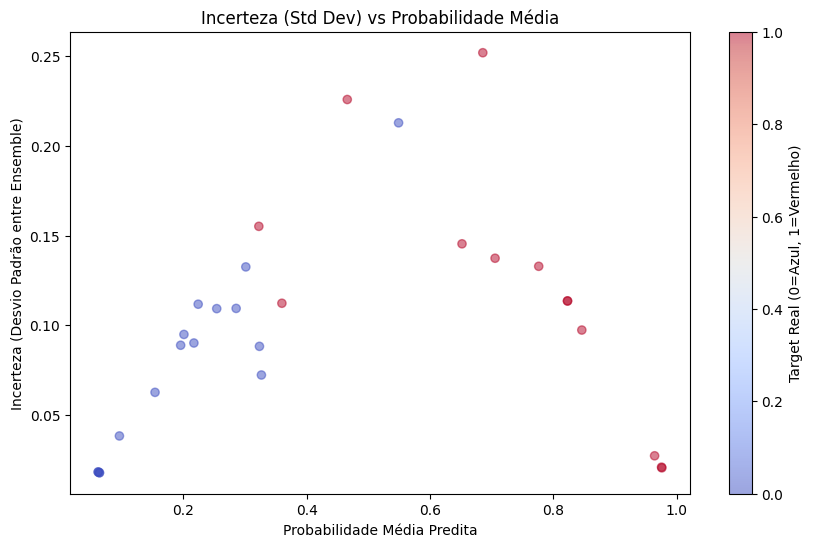

Incerteza média: 0.0979
Exemplo de alta incerteza (Index 0): Prob=0.69, Std=0.25

Calculando Importância de Features (Permutação)...


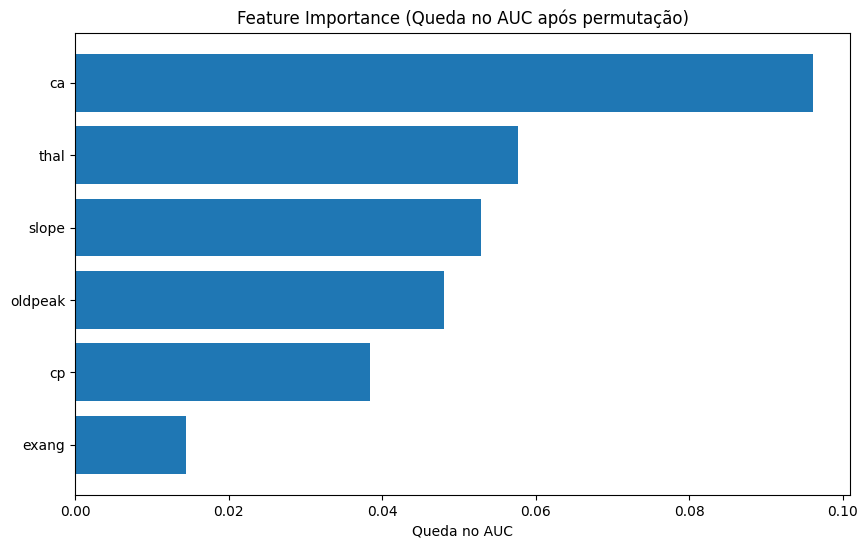

In [34]:
# ================================================================================
# CÉLULA 7: ESTIMATIVA DE INCERTEZA E IMPORTÂNCIA DE FEATURES
# ================================================================================

def analyze_uncertainty_and_features(model, X_num_val, X_cat_val, y_val, feature_names):
    """
    Analisa a incerteza das predições e a importância das features via permutação.
    """
    print("\n>>> Análise de Incerteza e Features <<<")
    model.eval()
    
    # 1. Incerteza (Desvio Padrão do Ensemble)
    X_num_t = torch.tensor(X_num_val).to(DEVICE)
    X_cat_t = torch.tensor(X_cat_val).to(DEVICE)
    
    with torch.no_grad():
        # Shape: (batch, k, 1)
        y_pred_raw = model(X_num_t, X_cat_t)
        probs_ensemble = torch.sigmoid(y_pred_raw).squeeze(-1).cpu().numpy() # (batch, k)
        
    # Média e Desvio Padrão das probabilidades
    mean_probs = probs_ensemble.mean(axis=1)
    std_probs = probs_ensemble.std(axis=1)
    
    # Plotar relação Probabilidade x Incerteza
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_probs, std_probs, alpha=0.5, c=y_val, cmap='coolwarm')
    plt.colorbar(label='Target Real (0=Azul, 1=Vermelho)')
    plt.title("Incerteza (Std Dev) vs Probabilidade Média")
    plt.xlabel("Probabilidade Média Predita")
    plt.ylabel("Incerteza (Desvio Padrão entre Ensemble)")
    plt.show()
    
    print(f"Incerteza média: {std_probs.mean():.4f}")
    print(f"Exemplo de alta incerteza (Index {np.argmax(std_probs)}): Prob={mean_probs[np.argmax(std_probs)]:.2f}, Std={std_probs.max():.2f}")
    
    # 2. Importância de Features (Permutation Importance)
    print("\nCalculando Importância de Features (Permutação)...")
    baseline_auc = roc_auc_score(y_val, mean_probs)
    importances = {}
    
    # Features Numéricas
    for i, name in enumerate(feature_names[:len(feature_names_num)]): # Assumindo ordem numéricas primeiro
        X_num_permuted = X_num_val.copy()
        np.random.shuffle(X_num_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(torch.tensor(X_num_permuted).to(DEVICE), X_cat_t)
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
            
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Features Categóricas
    for i, name in enumerate(feature_names[len(feature_names_num):]):
        X_cat_permuted = X_cat_val.copy()
        np.random.shuffle(X_cat_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(X_num_t, torch.tensor(X_cat_permuted).to(DEVICE))
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
        
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Plotar Importâncias
    sorted_feats = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    names, vals = zip(*sorted_feats)
    
    plt.figure(figsize=(10, 6))
    plt.barh(names, vals)
    plt.gca().invert_yaxis()
    plt.title("Feature Importance (Queda no AUC após permutação)")
    plt.xlabel("Queda no AUC")
    plt.show()

# Executar análise usando o último modelo treinado e dados de validação do último fold
# Precisamos recuperar os dados do último fold do loop anterior
# Como run_final_experiment é uma função, não temos acesso direto às variáveis locais.
# Vamos rodar uma rápida inferência em um split de validação para demonstrar.

print("Executando análise no último fold...")
# Recriar split do último fold manualmente para análise
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(skf.split(X_num, y))
last_train_idx, last_val_idx = splits[-1]

X_num_val_last = X_num[last_val_idx]
X_cat_val_last = X_cat[last_val_idx]
y_val_last = y[last_val_idx]

# Precisamos treinar o modelo neste fold para garantir que 'model' existe e está treinado
# Como 'model' é local em run_final_experiment, vamos treinar um rápido aqui ou modificar a função anterior.
# Para simplificar e não rodar tudo de novo, vou treinar um modelo rápido com os best_params neste split.

if 'best_params' in globals():
    final_model = create_tabm_model(len(feature_names_num), cat_cardinalities, best_params, X_train=torch.tensor(X_num[last_train_idx])).to(DEVICE)
    # Treino rápido para ter pesos não-aleatórios
    opt = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    crit = nn.BCEWithLogitsLoss()
    loader = DataLoader(TensorDataset(torch.tensor(X_num[last_train_idx]), torch.tensor(X_cat[last_train_idx]), torch.tensor(y[last_train_idx])), batch_size=256, shuffle=True)
    
    print("Treinando modelo para análise (pode levar alguns segundos)...")
    for _ in range(50): # 50 épocas suficiente para análise
        train_epoch(final_model, loader, opt, crit, DEVICE)
        
    all_features = feature_names_num + feature_names_cat
    analyze_uncertainty_and_features(final_model, X_num_val_last, X_cat_val_last, y_val_last, all_features)
else:
    print("Execute a otimização primeiro.")